In [1]:
import time
import json
import ast
import os
import datetime
from rich.progress import track

import io
from collections import defaultdict

import imageio
import boto3
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
# import seaborn as sns

from brtdevkit.core.db.athena import AthenaClient
from brtdevkit.data import Dataset
from timezonefinder import TimezoneFinderL
import pytz
from rich.progress import track
from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
from aletheia_dataset_creator.config.dataset_config import LEFT_CAMERAS, ALL_CAMERA_PAIRS_LIST
%matplotlib inline
pd.set_option('display.max_rows', 500)
import json
import cv2
import os
import multiprocessing as mp    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image
import imageio
from pathlib import Path
from dl.utils.mask_utils import fill_nan_geometries

%matplotlib inline
from cv.core.image_quality_server_side import ImageQuality

# from cv.core.image_quality_server_side_halo import ImageQuality
from dl.utils.config import DEFAULT_TONEMAP_PARAMS

In [2]:
directory = '/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/'
csv_name = 'master_annotations.csv' 
from dl.dataset.datamodes.npz.rgbd import RGBDNPZ
dataloader = RGBDNPZ(directory)

In [3]:
df = pd.read_csv(directory + csv_name)
df = df.drop_duplicates('unique_id')
df = df.sample(frac=1, ignore_index=True)
fill_nan_geometries(df)

/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (2,3,24,82,93,94,95,96,97,99,100,102,103,104,105,106,107,108,109,110,120,153,157,158,163,174,177,180,181,187,189,199,200,202,203,204,205,225,230,231,232,235,237,239,240,251,252,254,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,275,279,280,281,284,285,286,288) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df_1 = df[(df['camera_geometry_label'] == 'puk30') & (df['camera_location'] == 'T06') &  (df['camera_location_right'] == 'T08')].head(10)
df_small = df.groupby(['camera_geometry_label', 'camera_location','camera_location_right']).head(10)

In [21]:
total_count = defaultdict(lambda:0)
ego_count = {}
for i, row in track(df_1.iterrows(), total=len(df_1)):
    if row["camera_location"][0] == "I":
        continue  # No implement camera masks for now
    
    ego_ids = []
    for k, v in json.loads(row["label_map"]).items():
        if v[:3] == "Ego":
            ego_ids.append(int(k))
    l_cam = row['camera_location']
    r_cam = row['camera_location_right']
    label = dataloader.get_artifacts(row)['label']
    ego_key = (row["camera_geometry_label"], l_cam, r_cam)
    total_count[ego_key] += 1
    for id in ego_ids:
        label_is_ego = (label == id).astype(np.int32)
        if ego_key not in ego_count:
            ego_count[ego_key] = label_is_ego
        else:
            ego_count[ego_key] += label_is_ego
for ego_key in ego_count.keys():
    ego_count[ego_key] = ego_count[ego_key].astype(np.float32) / total_count[ego_key]


Output()

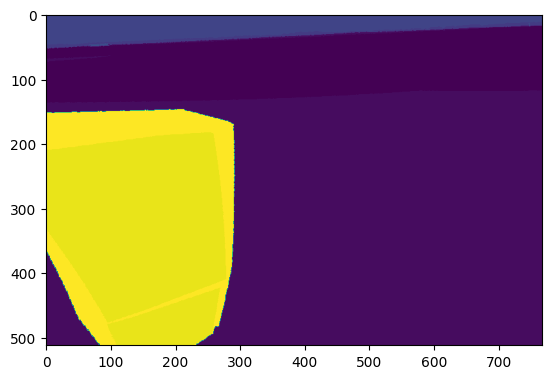

In [19]:
res = dataloader.get_artifacts(df_1.iloc[5])
plt.imshow(normalize_image(res['image'], hdr_mode=True))
plt.imshow(res['label'])

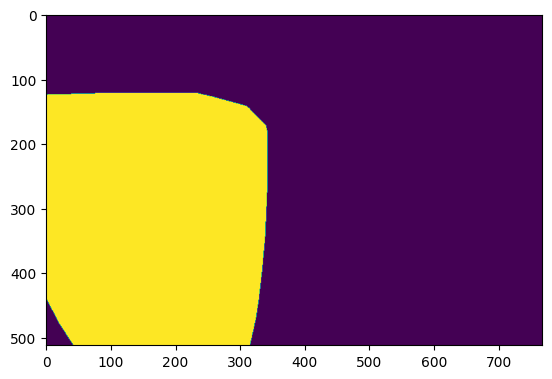

In [35]:
from scipy.spatial import ConvexHull
from skimage.draw import polygon
from skimage.morphology import binary_dilation

def expand_mask(image: np.ndarray) -> np.ndarray:
    image_binary = (image > 0.1).astype(np.uint8)
    x, y = np.where(image_binary > 0)
    points = np.stack([x, y], axis=1)
    if len(points) == 0:
        return np.zeros_like(image, dtype=np.uint8)
    else:
        hull = points[ConvexHull(points).vertices]
        rr, cc = polygon(hull[:, 0], hull[:, 1], image_binary.shape)
        image_binary[rr, cc] = 1
        image_binary_dilate = binary_dilation(image_binary, footprint=np.ones((51, 51)))
        image_out = (image_binary_dilate > 0).astype(np.uint8) * 255
        return image_out
out = expand_mask(ego_count[('puk30', 'T06', 'T08')])
plt.imshow(out)

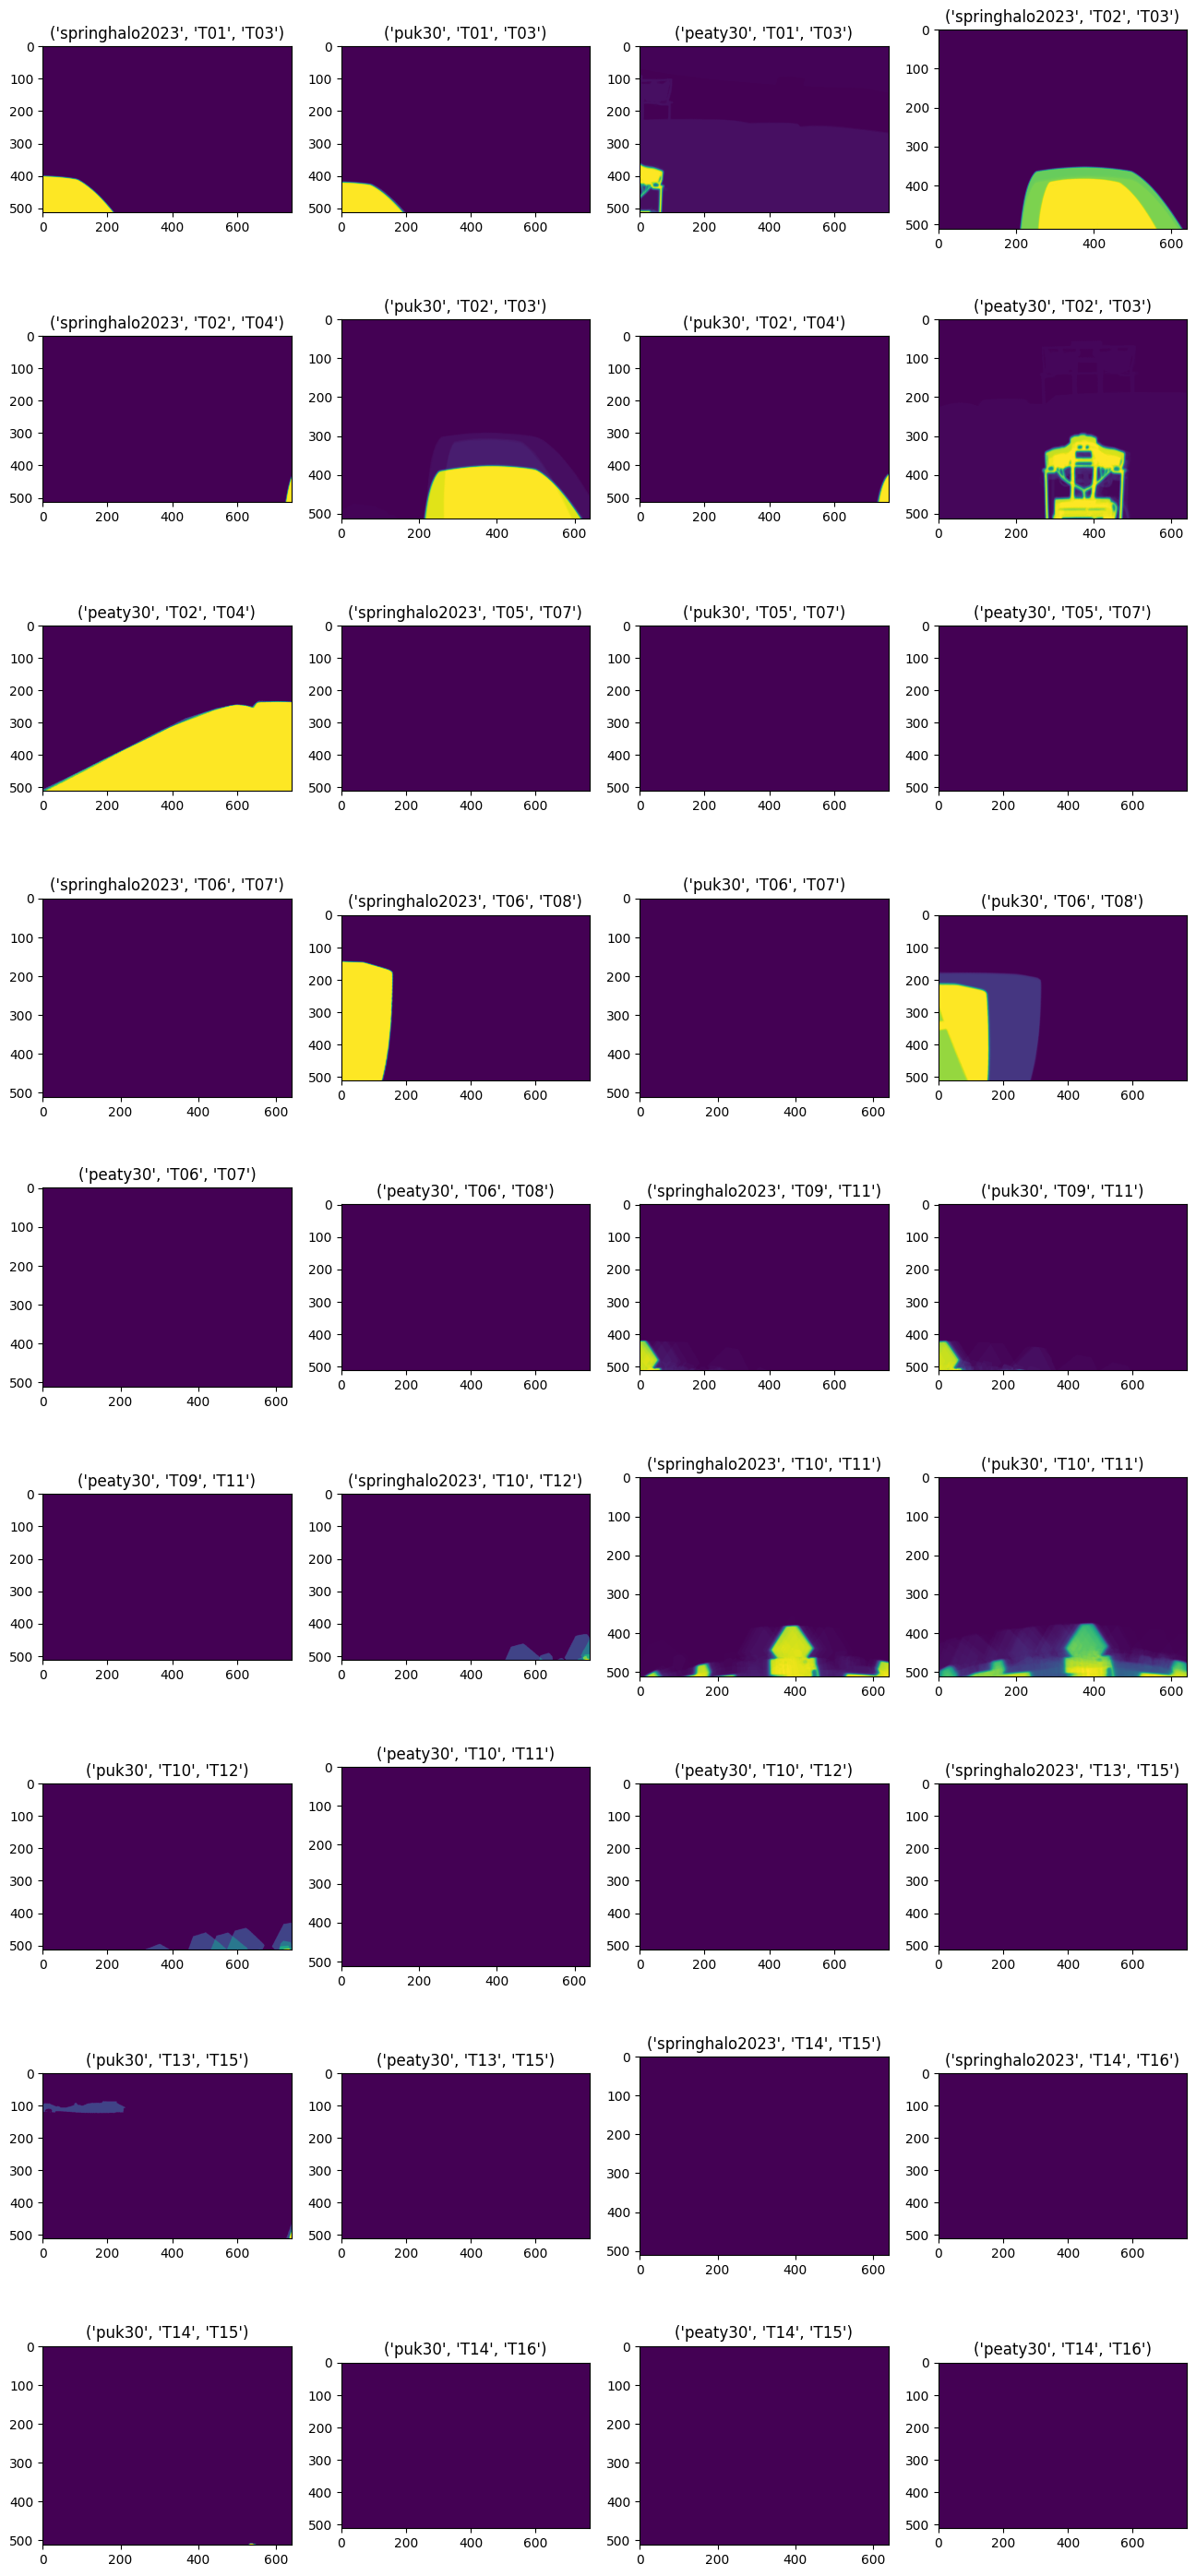

In [46]:
def plot_several_images(img_list, titles):
    cols = 4
    rows = (len(img_list) + 3) // cols
    fig, ax = plt.subplots(rows, cols, squeeze=False, figsize = (16, rows * 4))
    for i, img in enumerate(img_list):
        ax[i // cols][i % cols].imshow(img)
        ax[i // cols][i % cols].set_title(titles[i])
plot_several_images(ego_count.values(), list(ego_count.keys()))

In [18]:
image = list(ego_count.values())[0]

In [25]:
image > .5

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]]])

In [33]:
len(contours)

7

In [31]:
cv2.convexHull(contours[0])

array([[[ 30, 509]],

       [[ 32, 511]],

       [[  0, 511]],

       [[  0, 510]],

       [[  2, 509]]], dtype=int32)

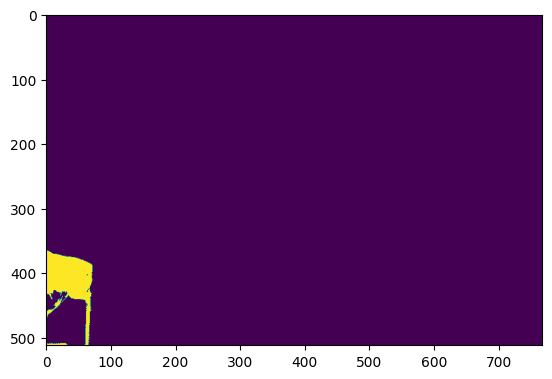

In [50]:
image_binary = np.uint8(image > .5) * 255
plt.imshow(image_binary)

In [51]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [65]:
x, y, _ = np.where(image_binary > 0)

In [66]:
points = np.stack([x, y], axis=1)

In [68]:
hull = ConvexHull(points)

In [70]:
hull # TODO

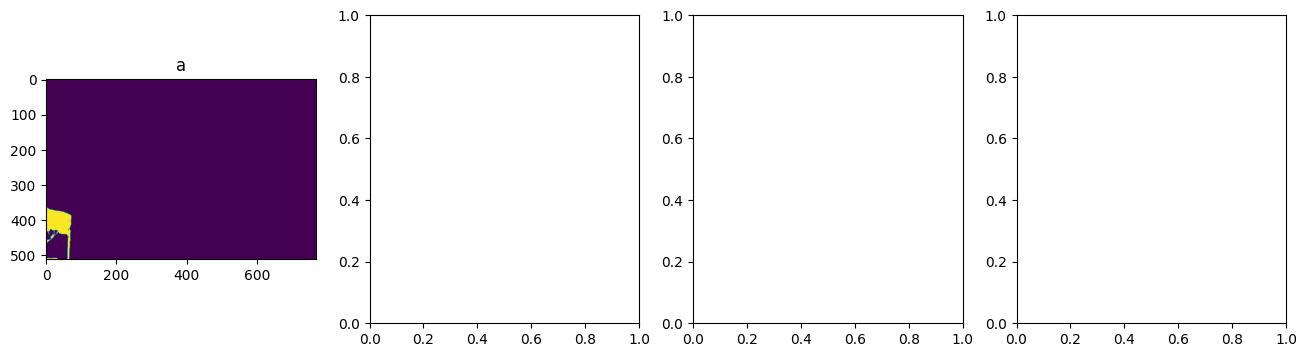

In [19]:
plot_several_images([image], ['a'])